# Import Library

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

%matplotlib inline

import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from PIL import Image


import os
import zipfile
import shutil
import random
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from shutil import copyfile


from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing

# Library Evaluation 
import shutil
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import pathlib

# Load Data

### Download data

In [2]:
shutil.rmtree('data', ignore_errors=True)

In [3]:
! mkdir data

In [4]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#Tidak Tau

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# os.remove('anime-recommendation-database-2020.zip')
! kaggle datasets download -d arashnic/book-recommendation-dataset
! mkdir data
! unzip book-recommendation-dataset.zip -d data/buku
os.remove('book-recommendation-dataset.zip')

 92% 22.0M/23.8M [00:02<00:00, 20.9MB/s]
100% 23.8M/23.8M [00:02<00:00, 12.1MB/s]
mkdir: cannot create directory ‘data’: File exists
Archive:  book-recommendation-dataset.zip
  inflating: data/buku/Books.csv     
  inflating: data/buku/Ratings.csv   
  inflating: data/buku/Users.csv     


### Read CSV

In [8]:
path_buku = '/content/data/buku/Books.csv'
path_user = '/content/data/buku/Users.csv'
path_rating = '/content/data/buku/Ratings.csv'


buku = pd.read_csv(path_buku)
user = pd.read_csv(path_user)
rating = pd.read_csv(path_rating)

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Data Understanding

Macam-macam file yang ada:
- `Books.csv` Berisi informasi Buku, seperti ID, Judul, penulis, penerbit, DSB.
- `Ratings.csv` Rating User terhadap Buku yang dibaca.
- `Users.csv` Informasi mengenai pengguna.


In [9]:
print('Jumlah data Buku: ', len(buku))
print('Jumlah data  user: ', len(user))
print('Jumlah data rating: ', len(rating))

Jumlah data Buku:  271360
Jumlah data  user:  278858
Jumlah data rating:  1149780


### Analisis data pada Books.csv

In [10]:
buku.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [11]:
buku = buku[["ISBN", "Book-Title", "Book-Author", "Year-Of-Publication", "Publisher"]]
buku.columns = ["ISBN", "Book_Title", "Book_Author", "Year_Of_Publication", "Publisher"]

In [12]:
buku.head()

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [13]:
print("Jumlah Buku berdasarkan ID:", len(buku.ISBN.unique()))

Jumlah Buku berdasarkan ID: 271360


In [14]:
print("Jumlah Publisher:", len(buku.Publisher.unique()))

Jumlah Publisher: 16808


cek data null

In [15]:
buku.isnull().sum()

ISBN                   0
Book_Title             0
Book_Author            1
Year_Of_Publication    0
Publisher              2
dtype: int64

cek duplicated data

In [16]:
buku.duplicated().sum()

0

In [17]:
# top rating
total_rating_complete_user = buku.Book_Author.value_counts()
pd.DataFrame({
    "Auhor": list(total_rating_complete_user.keys()),
    "Total": list(total_rating_complete_user)
}).head(10)

,Auhor,Total
0,Agatha Christie,632
1,William Shakespeare,567
2,Stephen King,524
3,Ann M. Martin,423
4,Carolyn Keene,373
5,Francine Pascal,372
6,Isaac Asimov,330
7,Nora Roberts,315
8,Barbara Cartland,307
9,Charles Dickens,302


### Analisis data pada rating.csv

This dataset only considers animes that the user has watched completely (watching_status==2) and gave it a score (score!=0)

In [18]:
rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [19]:
rating = rating[["User-ID", "ISBN", "Book-Rating"]]
rating.columns = ['user_id', 'ISBN', 'rating']

In [20]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1149780 non-null  int64 
 1   ISBN     1149780 non-null  object
 2   rating   1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


cek data null

In [21]:
rating.isnull().sum()

user_id    0
ISBN       0
rating     0
dtype: int64

cek ducplicated data

In [22]:
rating.duplicated().sum()

0

In [23]:
print("Jumlah aktivitas user terhadap anime:", len(rating.user_id.unique()))
print("Jumlah anime:", len(rating.ISBN.unique()))

Jumlah aktivitas user terhadap anime: 105283
Jumlah anime: 340556


In [24]:
# top rating
total_rating_complete_user = rating.rating.value_counts()
pd.DataFrame({
    "Rating": list(total_rating_complete_user.keys()),
    "Total": list(total_rating_complete_user)
})

,Rating,Total
0,0,716109
1,8,103736
2,10,78610
3,7,76457
4,9,67541
5,5,50974
6,6,36924
7,4,8904
8,3,5996
9,2,2759


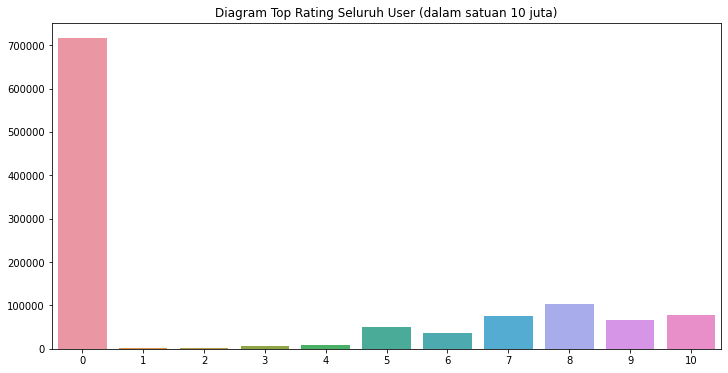

In [25]:
plt.figure(figsize=(12,6))
sns.barplot(x = list(total_rating_complete_user.keys()),
            y = list(total_rating_complete_user))
plt.title("Diagram Top Rating Seluruh User (dalam satuan 10 juta)")
plt.show()

### Analisis data pada animelist.csv

In [26]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [27]:
user = user[["User-ID", "Location", "Age"]]
user.columns = ['user_id', 'location', 'age']

cek data kosong

In [28]:
user.isnull().sum()

user_id          0
location         0
age         110762
dtype: int64

cek duplikasi data

In [29]:
user.duplicated().sum()

0

# Data Preparation

Memilih data yang akan digunakan

In [30]:
df_user = user
df_buku = buku
df_rating = rating

In [31]:
df_buku.head()

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [32]:
df_user.head()

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [33]:
df_rating.head()

,user_id,ISBN,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Dikarenakan pada data rating memiliki data yang bernilai 0 atau rating yangg bernilai 0 terlalu banyak, maka akan dilakukan penghapusan data

In [34]:
df_rating.drop(df_rating.loc[df_rating['rating']==0].index, inplace=True)

In [35]:
# top rating
total_rating_complete_user = df_rating.rating.value_counts()
pd.DataFrame({
    "Rating": list(total_rating_complete_user.keys()),
    "Total": list(total_rating_complete_user)
})

,Rating,Total
0,8,103736
1,10,78610
2,7,76457
3,9,67541
4,5,50974
5,6,36924
6,4,8904
7,3,5996
8,2,2759
9,1,1770


In [36]:
print("Jumlah anime yang digunakan:", len(df_rating.ISBN.unique()))
print("Jumlah user yang digunakan:", len(df_rating.user_id.unique()))
print("Jumlah rating user yang digunakan:", len(df_rating))

Jumlah anime yang digunakan: 185973
Jumlah user yang digunakan: 77805
Jumlah rating user yang digunakan: 433671


karena data terlalu besar, training model dilakukan hanya mengambil data sebanyak 1000 user saja

In [35]:
# user_ids = np.array(df_rating.user_id.unique().tolist())

# np.random.seed(42)
# np.random.shuffle(user_ids)
# user_ids = user_ids[:1000]

# df_rating = df_rating[df_rating.user_id.isin(user_ids)]

In [37]:
print("Jumlah anime yang digunakan:", len(df_rating.ISBN.unique()))
print("Jumlah user yang digunakan:", len(df_rating.user_id.unique()))
print("Jumlah rating user yang digunakan:", len(df_rating))

Jumlah anime yang digunakan: 185973
Jumlah user yang digunakan: 77805
Jumlah rating user yang digunakan: 433671


cek data hubungan anime dengan rating, apakah semua rating anime memiliki detail anime

In [38]:
df_merge = pd.merge(df_rating, df_buku[['user_id', 'Book_Title']], on='user_id', how='left')
df_merge.head()

,user_id,ISBN,rating,Book_Title
0,276726,0155061224,5,Rites of Passage
1,276729,052165615X,3,Help!: Level 1
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...
3,276736,3257224281,8,NaN
4,276737,0600570967,6,NaN


In [ ]:
df_merge = pd.merge(df_merge, df_buku[['ISBN', 'Book_Title']], on='ISBN', how='left')
df_merge.head()

In [39]:
df_merge.isna().sum()

user_id           0
ISBN              0
rating            0
Book_Title    49829
dtype: int64

Karena terlalu banyak data kosong pada judul Buku. Maka bisa dilakukan eliminasi.

In [40]:
df2 = df_merge.dropna()

In [41]:
df2.isna().sum()

user_id       0
ISBN          0
rating        0
Book_Title    0
dtype: int64

In [42]:
df2.head()

,user_id,ISBN,rating,Book_Title
0,276726,0155061224,5,Rites of Passage
1,276729,052165615X,3,Help!: Level 1
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...
5,276744,038550120X,7,A Painted House
7,276747,0060517794,9,Little Altars Everywhere


cek data hubungan anime dengan rating, apakah semua detail anime memiliki rating

In [43]:
df_merge2 = pd.merge(df_buku[['ISBN', 'Book_Title']], df_rating, on='ISBN', how='left')
df_merge2.head()

,ISBN,Book_Title,user_id,rating
0,0195153448,Classical Mythology,NaN,NaN
1,0002005018,Clara Callan,8.0,5.0
2,0002005018,Clara Callan,11676.0,8.0
3,0002005018,Clara Callan,67544.0,8.0
4,0002005018,Clara Callan,116866.0,9.0


In [44]:
df_merge2.isna().sum()

ISBN               0
Book_Title         0
user_id       121524
rating        121524
dtype: int64

Mengghapus data kosong

In [45]:
df3 = df_merge2.dropna()

In [46]:
df3.isna().sum()

ISBN          0
Book_Title    0
user_id       0
rating        0
dtype: int64

In [47]:
df3.head()

,ISBN,Book_Title,user_id,rating
1,0002005018,Clara Callan,8.0,5.0
2,0002005018,Clara Callan,11676.0,8.0
3,0002005018,Clara Callan,67544.0,8.0
4,0002005018,Clara Callan,116866.0,9.0
5,0002005018,Clara Callan,123629.0,9.0


terdapat 8763 data detail anime yang tidak memiliki rating

In [48]:
unused_anime_id = df_merge[df_merge.rating.isna()].ISBN.unique().tolist()

df_buku2 = df_buku[~(df_buku.ISBN.isin(unused_anime_id))]
print("Jumlah detail anime yang digunakan:", len(df_buku.ISBN.unique()))

Jumlah detail anime yang digunakan: 271360


save final data

In [49]:
df_rating.to_csv('final_rating.csv', index=False)
df_buku2.to_csv('final_buku.csv', index=False)

load final data

In [50]:
df_rating = pd.read_csv('final_rating.csv')
df_book = pd.read_csv('final_buku.csv')

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [51]:
df_rating

,user_id,ISBN,rating
0,276726,0155061224,5
1,276729,052165615X,3
2,276729,0521795028,6
3,276736,3257224281,8
4,276737,0600570967,6
...,...,...,...
433666,276704,0806917695,5
433667,276704,1563526298,9
433668,276709,0515107662,10
433669,276721,0590442449,10


encoding data

In [52]:
# Mengubah user_id menjadi list tanpa nilai yang sama
user_ids = df_rating['user_id'].unique().tolist()
 
# Melakukan encoding user_id
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
 
# Melakukan proses encoding angka ke ke user_id
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

In [53]:
# Mengubah book_id menjadi list tanpa nilai yang sama
book_ids = df_rating['ISBN'].unique().tolist()
 
# Melakukan proses encoding book_id
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}
 
# Melakukan proses encoding angka ke book_id
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}

In [54]:
# Mapping user_id ke dataframe user
df_rating['user'] = df_rating['user_id'].map(user_to_user_encoded)
 
# Mapping book_id ke dataframe book
df_rating['book'] = df_rating['ISBN'].map(book_to_book_encoded)

In [55]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)
 
# Mendapatkan jumlah book
num_book = len(book_encoded_to_book)
print(num_book)
 
# Mengubah rating menjadi nilai float
df_rating['rating'] = df_rating['rating'].values.astype(np.float32)
 
# Nilai minimum rating
min_rating = min(df_rating['rating'])
 
# Nilai maksimal rating
max_rating = max(df_rating['rating'])
 
print('Number of User: {}, Number of Book: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_book, min_rating, max_rating
))

77805
185973
Number of User: 77805, Number of Book: 185973, Min Rating: 1.0, Max Rating: 10.0


In [56]:
# Mengacak dataset
df_rating = df_rating.sample(frac=1, random_state=42)
df_rating

,user_id,ISBN,rating,user,book
60315,32440,0380018179,8.0,9713,1013
84421,49144,8422641127,5.0,14390,54663
254428,156424,3442453844,7.0,44370,127953
12156,7125,0060586125,8.0,2587,10359
398619,251606,0316789844,8.0,70897,7053
...,...,...,...,...,...
259178,159834,0441132456,7.0,45235,70428
365838,231613,0747542333,5.0,65186,33018
131932,79923,0440206154,8.0,22993,6822
146867,89610,8880891960,5.0,25753,84887


splitting data

In [57]:
# Membuat variabel x untuk mencocokkan data user_id dan book_id menjadi satu value
x = df_rating[['user', 'book']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df_rating['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 90% data train dan 10% data validasi
train_indices = int(0.8 * df_rating.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x[:10], y[:10])

[[  9713   1013]
 [ 14390  54663]
 [ 44370 127953]
 [  2587  10359]
 [ 70897   7053]
 [  6851  20259]
 [ 68119 170886]
 [  4969  25387]
 [ 77134  13676]
 [ 53524 146013]] [0.77777778 0.44444444 0.66666667 0.77777778 0.77777778 1.
 1.         0.88888889 1.         0.66666667]


In [58]:
print(f'Total # of sample in whole dataset: {len(x)}')
print(f'Total # of sample in train dataset: {len(x_train)}')
print(f'Total # of sample in test dataset: {len(x_val)}')

Total # of sample in whole dataset: 433671
Total # of sample in train dataset: 346936
Total # of sample in test dataset: 86735


# Model Development

In [59]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_book, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_book = num_book
    self.embedding_size = embedding_size
    self.user_embedding = tf.keras.layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
    )
    self.user_bias = tf.keras.layers.Embedding(num_users, 1) # layer embedding user bias
    self.book_embedding = tf.keras.layers.Embedding( # layer embeddings book
        num_book,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
    )
    self.book_bias = tf.keras.layers.Embedding(num_book, 1) # layer embedding buku bias
    self.dense1 = tf.keras.layers.Dense(32, activation=tf.nn.relu) # layer dense
    self.dense2 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid) # layer output activation sigmoid
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0]) 
    book_vector = self.book_embedding(inputs[:, 1]) 
    book_bias = self.book_bias(inputs[:, 1]) 
 
    dot_user_book = tf.tensordot(user_vector, book_vector, 2) 
 
    x = dot_user_book + user_bias + book_bias
    x = self.dense1(x)
    x = self.dense2(x)
    return x

In [60]:
def create_model(optimizer, embedding_size):
    tf_model = RecommenderNet(num_users, num_book, embedding_size)
    tf_model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = optimizer,
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return tf_model

In [61]:
# Memulai training
import warnings
warnings.filterwarnings('ignore')

In [62]:
model_params = {
    'optimizer': ['Adam', 'RMSprop'],
    'embedding_size': [50, 100]
}

model = {}
history = {}
params = {}

print("Training Parameter: ", model_params)

k = 1
for i in range(2):
    for j in range(2):
        opt = model_params['optimizer'][i]
        emb_size = model_params['embedding_size'][j]

        print("Start Training with optimizer: {} embedding_size: {}".format(opt, emb_size))
        model["model_"+str(k)] = create_model(
            optimizer=opt,
            embedding_size=emb_size,
        )

        history["model_"+str(k)] = model["model_"+str(k)].fit(
            x = x_train,
            y = y_train,
            batch_size = 64,
            epochs = 10,
            validation_data = (x_val, y_val)
        )

        params["model_"+str(k)] = "opt: {}, emb_size: {}".format(opt, emb_size)
        k = k + 1

print("Finish Training")

Training Parameter:  {'optimizer': ['Adam', 'RMSprop'], 'embedding_size': [50, 100]}
Start Training with optimizer: Adam embedding_size: 50
Epoch 1/10
5421/5421 [==============================] - 56s 9ms/step - loss: 0.5726 - root_mean_squared_error: 0.1950 - val_loss: 0.5724 - val_root_mean_squared_error: 0.1907
Epoch 2/10
5421/5421 [==============================] - 46s 8ms/step - loss: 0.5749 - root_mean_squared_error: 0.1920 - val_loss: 0.5714 - val_root_mean_squared_error: 0.1873
Epoch 3/10
5421/5421 [==============================] - 49s 9ms/step - loss: 0.5715 - root_mean_squared_error: 0.1871 - val_loss: 0.5709 - val_root_mean_squared_error: 0.1859
Epoch 4/10
5421/5421 [==============================] - 45s 8ms/step - loss: 0.5679 - root_mean_squared_error: 0.1828 - val_loss: 0.5700 - val_root_mean_squared_error: 0.1842
Epoch 5/10
5421/5421 [==============================] - 47s 9ms/step - loss: 0.5660 - root_mean_squared_error: 0.1805 - val_loss: 0.5695 - val_root_mean_squared

# Evaluation

In [63]:
print("Modelname -- Parameter")
for k, v in params.items():
  print("{} -- {}".format(k, v))

Modelname -- Parameter
model_1 -- opt: Adam, emb_size: 50
model_2 -- opt: Adam, emb_size: 100
model_3 -- opt: RMSprop, emb_size: 50
model_4 -- opt: RMSprop, emb_size: 100


## Plot History Setiap Model

In [64]:
list_modelnames = list(history.keys())

dict_acc = {}
dict_val_acc = {}
dict_loss = {}
dict_val_loss = {}

for modelname, modelhistory in history.items():
  dict_acc[modelname] = modelhistory.history['root_mean_squared_error']
  dict_val_acc[modelname] = modelhistory.history['val_root_mean_squared_error']
  dict_loss[modelname] = modelhistory.history['loss']
  dict_val_loss[modelname] = modelhistory.history['val_loss']

label_plot = list_modelnames
marker_plot = ['o','x','v','^']

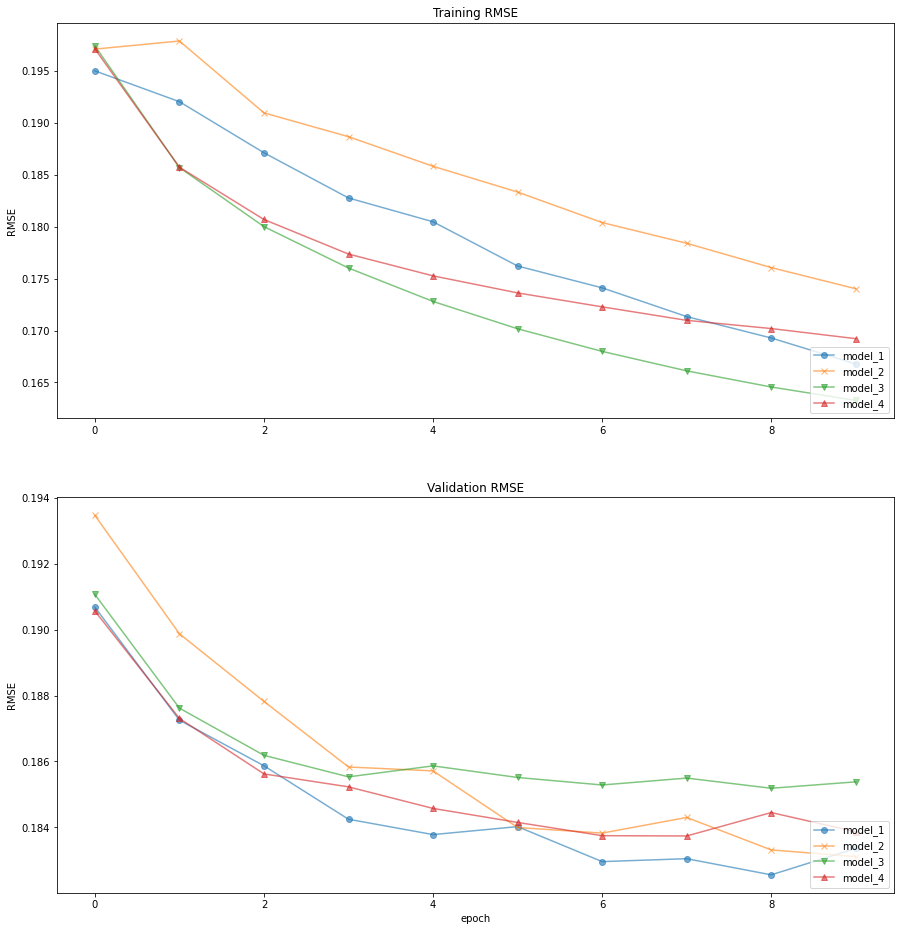

In [65]:
plt.figure(figsize=(15, 16))
plt.subplot(2, 1, 1)
for i in range(len(list_modelnames)):
  plt.plot(dict_acc[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)

plt.legend(loc='lower right')
plt.ylabel('RMSE')
plt.title('Training RMSE')

plt.subplot(2, 1, 2)
for i in range(len(list_modelnames)):
  plt.plot(dict_val_acc[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)

plt.legend(loc='lower right')
plt.ylabel('RMSE')
plt.title('Validation RMSE')
plt.xlabel('epoch')
plt.savefig('acc_all_model.png')

plt.show()

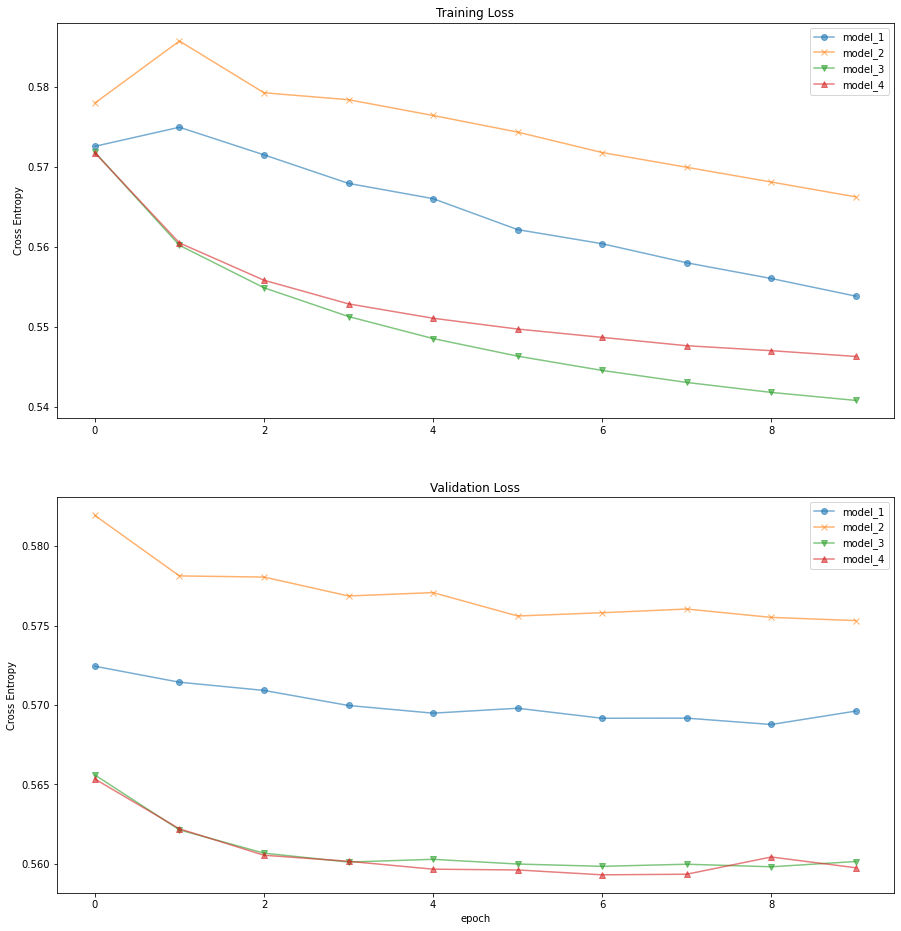

In [66]:
plt.figure(figsize=(15, 16))
plt.subplot(2, 1, 1)

for i in range(len(list_modelnames)):
  plt.plot(dict_loss[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)

plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training Loss')

plt.subplot(2, 1, 2)

for i in range(len(list_modelnames)):
  plt.plot(dict_val_loss[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)
  
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Validation Loss')
plt.xlabel('epoch')

plt.savefig('loss_all_model.png')

plt.show()


## Membandingkan Metrik Evaluasi Setiap Model

In [67]:
# evaluate all model
dict_score_train = {}
dict_score_valid = {}

for modelname, modelresult in model.items():
  dict_score_train[modelname] = modelresult.evaluate(x_train, y_train)
  dict_score_valid[modelname] = modelresult.evaluate(x_val, y_val)

2711/2711 [==============================] - 11s 4ms/step - loss: 0.5594 - root_mean_squared_error: 0.1836


In [68]:
# prepare data before plot
df1 = pd.DataFrame({
    'Model': list_modelnames,
    'Train': [eval[1] for eval in dict_score_train.values()],
    'Valid': [eval[1] for eval in dict_score_valid.values()],
})

df2 = pd.DataFrame({
    'Model': list_modelnames,
    'Train': [eval[0] for eval in dict_score_train.values()],
    'Valid': [eval[0] for eval in dict_score_valid.values()],
})

tidy1 = df1.melt(id_vars='Model').rename(columns=str.title)

tidy2 = df2.melt(id_vars='Model').rename(columns=str.title)

In [69]:
df2

,Model,Train,Valid
0,model_1,0.550387,0.568281
1,model_2,0.566875,0.574132
2,model_3,0.537243,0.559763
3,model_4,0.542772,0.559444


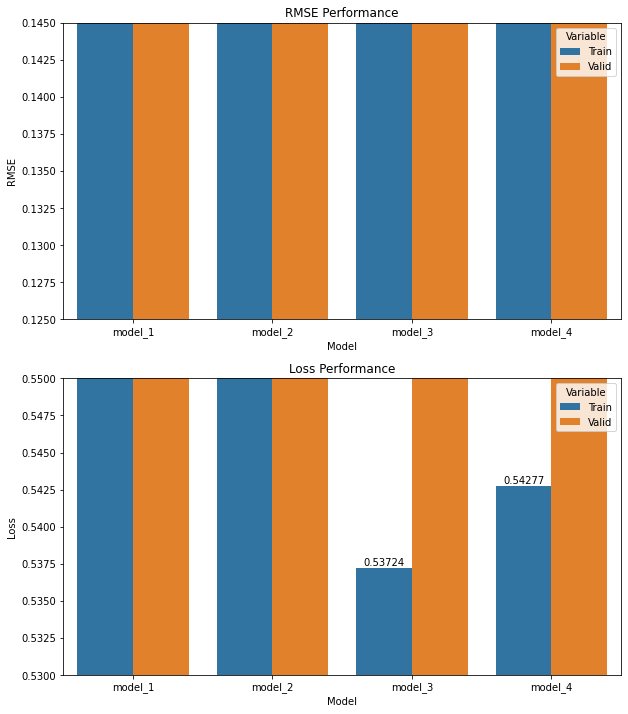

In [70]:
# plot comparison all models evaluate
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# first plot
sns.barplot(x='Model', y='Value', hue='Variable', data=tidy1, ax=ax1)
ax1.set_ylabel('RMSE')
ax1.set_ylim([0.125, 0.145])
ax1.set_title('RMSE Performance')

for p, data in zip(ax1.patches, tidy1['Value']):
    ax1.annotate(round(data, 5), xy=(p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom')

# second plot
sns.barplot(x='Model', y='Value', hue='Variable', data=tidy2, ax=ax2)
ax2.set_ylabel('Loss')
ax2.set_ylim([0.53, 0.55])
ax2.set_title('Loss Performance')

for p, data in zip(ax2.patches, tidy2['Value']):
    ax2.annotate(round(data, 5), xy=(p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom')

plt.savefig('evaluate_all_model.png')
plt.show()

model_3 (opt: RMSprop, emb_size: 50) dipilih karena memiliki tingkat RMSE paling rendah dan loss relatif rendah

## Mengambil Rekomendasi Satu User

In [76]:
# Mengambil sample user
user_id = df_rating.user_id.sample(1).iloc[0]
book_watched_by_user = df_rating[df_rating.user_id == user_id]
 
book_not_watched = df_book[~df_book['ISBN'].isin(book_watched_by_user.ISBN.values)]['ISBN'] 
book_not_watched = list(
    set(book_not_watched)
    .intersection(set(book_to_book_encoded.keys()))
)
 
book_not_watched = [[book_to_book_encoded.get(x)] for x in book_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_watched), book_not_watched)
)

In [81]:
ratings_predict = model["model_3"].predict(user_book_array).flatten()
 
top_ratings_indices = ratings_predict.argsort()[-10:][::-1]
recommended_book_ids = [
    book_encoded_to_book.get(book_not_watched[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('====' * 10)
print('Top 10 book with high ratings from user')
print('----' * 10)
 
top_book_user = (
    book_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(10)
    .ISBN.values
)

df_book_rows = df_book[df_book['ISBN'].isin(top_book_user)]
for row in df_book_rows.itertuples():
    print("{} ({}) : {}".format(row.Book_Title, row.Publisher, row.Book_Author))
 
print('----' * 10)
print('Top 10 book recommendation')
print('----' * 10)
 
recommended_book = df_book[df_book['ISBN'].isin(recommended_book_ids)]
for row in recommended_book.itertuples():
    print("{} ({}) : {}".format(row.Book_Title, row.Publisher, row.Book_Author))

4682/4682 [==============================] - 10s 2ms/step
Showing recommendations for users: 238008
Top 10 book with high ratings from user
----------------------------------------
The Big Sleep (Vintage Books USA) : Raymond Chandler
Heartbreaker (Pocket) : Julie Garwood
The Mulberry Tree (Pocket) : Jude Deveraux
The Runaway Princess (Avon) : Christina Dodd
The Beauty Myth: How Images of Beauty Are Used Against Women (Anchor) : Naomi Wolf
I Thee Wed (Bantam Books) : Amanda Quick
Surrender My Love (Avon) : Johanna Lindsey
Wise Blood : A Novel (Farrar, Straus and Giroux) : Flannery O'Connor
The Greatest Lover in All England (HarperTorch) : Christina Dodd
Cranford ; Cousin Phillis (Penguin English Library) (Penguin Books) : Elizabeth Cleghorn Stevenson Gaskell
----------------------------------------
Top 10 book recommendation
----------------------------------------
The Fellowship of the Ring (The Lord of the Rings, Part 1) (Del Rey) : J.R.R. TOLKIEN
Harry Potter and the Sorcerer's Stone

In [82]:
print("Book with high ratings from user")
df_book_rows

Book with high ratings from user


,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher
1504,0394758285,The Big Sleep,Raymond Chandler,1992,Vintage Books USA
4056,0671034006,Heartbreaker,Julie Garwood,2001,Pocket
4448,0743437640,The Mulberry Tree,Jude Deveraux,2003,Pocket
7434,0380802929,The Runaway Princess,Christina Dodd,1999,Avon
11957,0385423977,The Beauty Myth: How Images of Beauty Are Used...,Naomi Wolf,1992,Anchor
22533,0553574108,I Thee Wed,Amanda Quick,2000,Bantam Books
25595,0380762560,Surrender My Love,Johanna Lindsey,1994,Avon
165238,0374505845,Wise Blood : A Novel,Flannery O'Connor,1962,"Farrar, Straus and Giroux"
268033,0061081531,The Greatest Lover in All England,Christina Dodd,1994,HarperTorch
268035,0140431047,Cranford ; Cousin Phillis (Penguin English Lib...,Elizabeth Cleghorn Stevenson Gaskell,1977,Penguin Books


In [83]:
print("Top 10 Book recommendation")
recommended_book

Top 10 Book recommendation


,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher
1571,0345339703,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. TOLKIEN,1986,Del Rey
2143,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
2809,0590353403,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,Scholastic
3839,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic
3847,0064400557,Charlotte's Web (Trophy Newbery),E. B. White,1974,HarperTrophy
4206,0345339738,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,1986,Del Rey
5431,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic
5506,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic
6330,0439136369,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2001,Scholastic
9026,043936213X,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,2001,Scholastic


Top Author user likes and recommendation

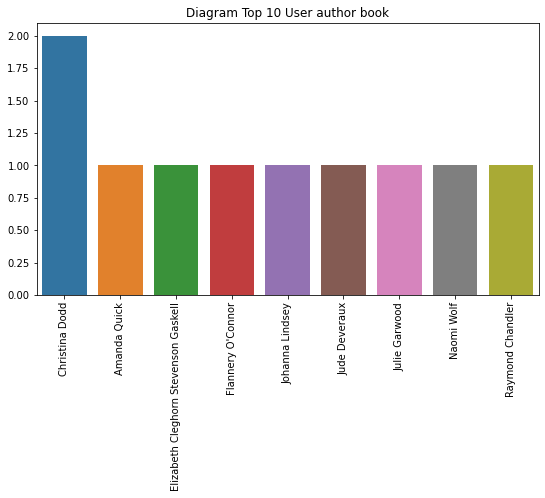

In [86]:
user_authors = []
list_book_authors = df_book_rows.Book_Author.unique()

for i, v in enumerate(list_book_authors):
  user_authors.extend(v.split(', '))

user_authors = sorted(set(user_authors))

total_author_by_user = {g: 0 for g in user_authors}

for book_author in df_book_rows['Book_Author']:
  list_book_author = book_author.split(', ')
  for author in list_book_author:
    total_author_by_user[author] = total_author_by_user[author] + 1

total_author_by_user = dict(sorted(total_author_by_user.items(), key=lambda x:x[1], reverse=True))

plt.figure(figsize=(9,5))
sns.barplot(x = list(total_author_by_user.keys())[:10],
            y = list(total_author_by_user.values())[:10],
            )
plt.xticks(rotation=90)
plt.title("Diagram Top 10 User author book")
plt.show()

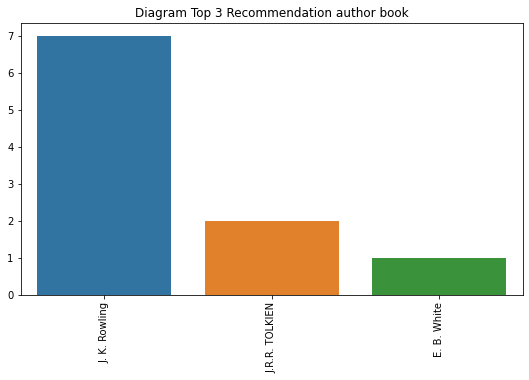

In [88]:
recommended_authors = []
list_book_authors = recommended_book.Book_Author.unique()

for i, v in enumerate(list_book_authors):
  recommended_authors.extend(v.split(', '))

recommended_authors = sorted(set(recommended_authors))

total_author_by_recommendation = {g: 0 for g in recommended_authors}

for book_author in recommended_book['Book_Author']:
  list_book_author = book_author.split(', ')
  for author in list_book_author:
    total_author_by_recommendation[author] = total_author_by_recommendation[author] + 1

total_author_by_recommendation = dict(sorted(total_author_by_recommendation.items(), key=lambda x:x[1], reverse=True))

plt.figure(figsize=(9,5))
sns.barplot(x = list(total_author_by_recommendation.keys())[:10],
            y = list(total_author_by_recommendation.values())[:10],
            )
plt.xticks(rotation=90)
plt.title("Diagram Top 3 Recommendation author book")
plt.show()